In [1]:
# Config文件
import torch
import numpy as np
from torch.backends import cudnn

cudnn.benchmark = False
cudnn.deterministic = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

SEED = 2
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)


batch_size = 256
lr = 0.1
num_epoch = 10

In [2]:
# util文件
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

train_trans = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5),
                transforms.Resize((96, 96)),
                transforms.ToTensor()])
test_trans = transforms.Compose([transforms.Resize((96, 96)),
                    transforms.ToTensor()])

train_dataset = torchvision.datasets.CIFAR10(root='../data', train=True,
                            transform=train_trans,
                            download=True)
test_dataset = torchvision.datasets.CIFAR10(root='../data', train=False,
                            transform=test_trans,
                            download=True)


train_iter = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_iter = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

def get_labels(labels):
    """
    根据y的值返回对应的label文字
    """
    text_labels = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse',
                   'ship', 'truck', 'Total']
    if torch.is_tensor(labels):
        return [text_labels[int(i)] for i in labels]
    elif type(labels) == int:
        return text_labels[labels]


def show_image(imgs, title=None):
    """
    实现图片展示

    notes: 如果用之前的 reshape的话，3个通道reshape掉会很奇怪，因此这里使用np.transpose来实现
    """
    if imgs.dim() == 4:
        plt.figure(figsize=(4 * imgs.shape[0], 4))
        for i, img in enumerate(imgs):
            if img.shape == (3, 96, 96):
                img = np.transpose(img.data.cpu().numpy(), (1, 2, 0))
            plt.subplot(1, imgs.shape[0], i+1)
            if title:
                plt.title(title[i])
            plt.imshow(img)
        plt.show()

    if imgs.dim() == 3:
        if imgs.shape == (3, 96, 96):
            img = np.transpose(imgs.data.cpu().numpy(), (1, 2, 0))

            plt.imshow(img)
            plt.title(title)
            plt.show()

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified


# 主文件开始

In [3]:
from torch import nn, optim
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
from tqdm import tqdm

In [4]:
class Residual(nn.Module):
    """
    实现一个残差连接网络的一个block, 不会改变输入的形状

    use_1x1conv是残差连接时,是否要做一次卷积(1X1卷积可以认为是一个特殊的全连接层)

    Note:
         input_channels == num_channerls -> use_1X1conv 都可以运行
         input_channels != num_channerls -> use_1X1conv 必须等于True
         这里是因为残差连接 Y和 X shape 的不一致
    """
    def __init__(self, input_channels, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.use_1x1conv = use_1x1conv

        self.conv1 = nn.Conv2d(input_channels, num_channels, kernel_size=3,padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1)

        # conv3是1x1卷积,就是残差连接的时候要不要做一个全连接
        self.conv3 = nn.Conv2d(input_channels, num_channels, kernel_size=1, stride=strides)

        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        Y = self.relu(self.bn1(self.conv1(x)))
        Y = self.bn2(self.conv2(Y))

        if self.use_1x1conv:
            x = self.conv3(x)
        Y += x
        return self.relu(Y)


class Residual_Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.block_1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
                                     nn.BatchNorm2d(64), nn.ReLU(inplace=True),
                                     nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
        self.block_2 = nn.Sequential(Residual(64, 64),
                                     Residual(64, 64, use_1x1conv=True, strides=2))
        self.block_3 = nn.Sequential(Residual(64, 128, use_1x1conv=True, strides=2),
                                     Residual(128, 128))
        self.block_4 = nn.Sequential(Residual(128, 256, use_1x1conv=True, strides=2),
                                     Residual(256, 256))
        self.block_5 = nn.Sequential(Residual(256, 512, use_1x1conv=True, strides=2),
                                     Residual(512, 512))
        self.block_6 = nn.Sequential(nn.AdaptiveAvgPool2d((1, 1)),
                                     nn.Flatten(),
                                     nn.Linear(512, 10))

    def forward(self, x):
        # x.shape = [batch, 1, 96, 96]
        out = self.block_1(x)
        # [batch, 1, 96, 96] -> [batch, 64, 48, 48]
        out = self.block_2(out)
        # [batch, 64, 48, 48] -> [batch, 64, 24, 24]
        out = self.block_3(out)
        # [batch, 64, 24, 24] -> [batch, 128, 12, 12]
        out = self.block_4(out)
        # [batch, 128, 12, 12] -> [batch, 256, 6, 6]
        out = self.block_5(out)
        # [batch, 256, 6, 6] -> [batch, 512, 3, 3]
        out = self.block_6(out)
        # [batch, 512, 3, 3] -> [batch, 10]
        return out


def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        nn.init.xavier_uniform_(m.weight)

In [5]:
Model = Residual_Net().to(device)
Model.apply(init_weights)  # 不用这个初始化的话,效果很差
optimizer = optim.SGD(Model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss().to(device)
step = 0

for epoch in range(num_epoch):
    Model.train()
    train_accuracy_list = []
    for batch_x, batch_y in tqdm(train_iter):
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        out = Model(batch_x)
        loss = criterion(out, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_pred = torch.argmax(out, dim=1)
        accuracy = accuracy_score(batch_y.detach().cpu().numpy(), y_pred.detach().cpu().numpy())
        train_accuracy_list.append(accuracy)


        step += 1

    train_accuracy_list = np.array(train_accuracy_list)
    avg_acc = train_accuracy_list.mean()
    tqdm.write(f'epoch:{epoch + 1}, train_accuracy:{avg_acc}')

    with torch.no_grad():
        Model.eval()
        test_accuracy_list = []
        for batch_x, batch_y in test_iter:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            out = Model(batch_x)
            y_pred = torch.argmax(out, dim=1)
            accuracy = accuracy_score(batch_y.detach().cpu().numpy(), y_pred.detach().cpu().numpy())
            test_accuracy_list.append(accuracy)

        test_accuracy_list = np.array(test_accuracy_list)
        test_acc = np.mean(test_accuracy_list)
        tqdm.write(f'epoch:{epoch + 1}, test_accuracy{test_acc}')

100%|██████████| 196/196 [00:41<00:00,  4.75it/s]


epoch:1, train_accuracy:0.4284837372448979
epoch:1, test_accuracy0.19794921875


100%|██████████| 196/196 [00:40<00:00,  4.88it/s]


epoch:2, train_accuracy:0.5919762436224489
epoch:2, test_accuracy0.3611328125


100%|██████████| 196/196 [00:40<00:00,  4.80it/s]


epoch:3, train_accuracy:0.6634526466836735
epoch:3, test_accuracy0.5908203125


100%|██████████| 196/196 [00:40<00:00,  4.80it/s]


epoch:4, train_accuracy:0.7147441007653061
epoch:4, test_accuracy0.53818359375


100%|██████████| 196/196 [00:41<00:00,  4.71it/s]


epoch:5, train_accuracy:0.7511200573979592
epoch:5, test_accuracy0.6037109375


100%|██████████| 196/196 [00:41<00:00,  4.78it/s]


epoch:6, train_accuracy:0.7805365114795918
epoch:6, test_accuracy0.669921875


100%|██████████| 196/196 [00:40<00:00,  4.80it/s]


epoch:7, train_accuracy:0.8108219068877551
epoch:7, test_accuracy0.5626953125


100%|██████████| 196/196 [00:41<00:00,  4.72it/s]


epoch:8, train_accuracy:0.8382772640306123
epoch:8, test_accuracy0.64658203125


100%|██████████| 196/196 [00:41<00:00,  4.76it/s]


epoch:9, train_accuracy:0.8576769770408164
epoch:9, test_accuracy0.33330078125


100%|██████████| 196/196 [00:40<00:00,  4.79it/s]


epoch:10, train_accuracy:0.8777662627551021
epoch:10, test_accuracy0.61923828125


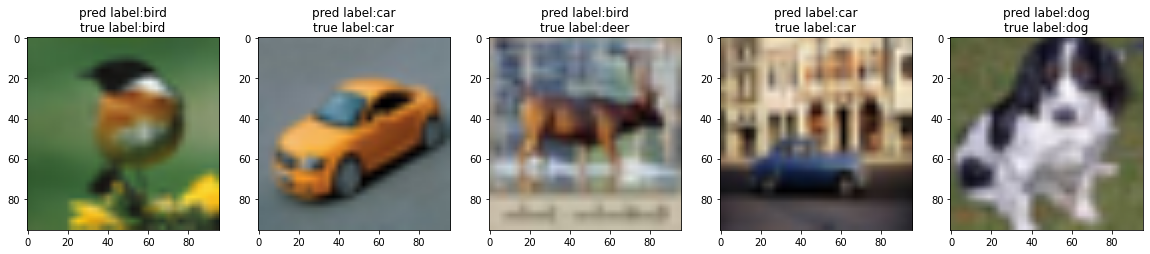

In [6]:
eval_iter = DataLoader(train_dataset, batch_size=5, shuffle=True)
x, y = next(iter(eval_iter))
x = x.to(device)
y = y.to(device)
Model.eval()
out = Model(x)
pred = torch.argmax(out, dim=1)

pred_titles = get_labels(pred)
true_titles = get_labels(y)
title = ["pred label:" + pred_title + '\n' + 'true label:' + true_title
            for pred_title, true_title in zip(pred_titles, true_titles)]
show_image(x, title=title)